In [ ]:
!pip install -q datasets[audio] librosa transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00


## Clusterization with faiss

#### Add siameze embeddings to an images dataset

In [ ]:
from datasets import load_dataset

#source_ds = 'fma_small_images'
source_ds = '8000_large_4'

#dest_ds = 'siamese_clusters'
dest_ds = '8000_large_4_siamclusters'

ds = load_dataset(f'arieg/{source_ds}', split='train')
ds = ds.rename_column('label', 'track_id')

In [ ]:
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
import numpy as np

folder = '/content/drive/MyDrive/Colab Notebooks/Zama'
siamese_embedding_model = keras.models.load_model(f"{folder}/embedding_network_512.h5")

In [ ]:
def image_embedding(image, model):
    #convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for inference
    image = preprocess_input(image)
    # predict the probability across all output classes
    yhat = model.predict(image, verbose=0)

    return yhat

def add_siamese_embeddings(sample):
    sample['siam_embedding'] = image_embedding(sample['image'], siamese_embedding_model)
    return sample

In [ ]:
ds = ds.map(add_siamese_embeddings)

ds.set_format('numpy')
embeddings = ds['siam_embedding'].squeeze(axis=1)

Map:   0%|          | 0/7997 [00:00<?, ? examples/s]

### Clusterization

In [ ]:
!pip install -q faiss-gpu
import faiss

ncentroids = 80
niter = 20
verbose = True
d = embeddings.shape[1]
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(embeddings)

# kmeans.centroids contains centroids' vectors
# kmeans.centroids.shape = (80, embedding_size)

# I is a mapping between tracks (i.e. track embeddings) and centroid (cluster) index
_, I = kmeans.index.search(embeddings, 1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 19.4 MB/s eta 0:00:00


In [ ]:
embedding_method = 'siamese'

np.save(f"/content/drive/MyDrive/Colab Notebooks/Zama/{embedding_method}_centroids.npy", kmeans.centroids)
np.save(f"/content/drive/MyDrive/Colab Notebooks/Zama/{embedding_method}_cluster_idxs.npy", I)

## Backup

### Audio embeddings m-a-p/MERT-v1-95M
and creation of clusters based on these embeddings




In [ ]:
!pip install -q librosa audiomentations transformers

In [ ]:
import librosa
from glob import glob
from pathlib import Path
import numpy as np
from IPython.display import Audio
import PIL
from PIL import Image
from tqdm import tqdm
import os
import torchaudio

In [ ]:
# from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2FeatureExtractor
from transformers import AutoModel
import torch
from torch import nn
import torchaudio.transforms as T


# loading our model weights
model = AutoModel.from_pretrained("m-a-p/MERT-v1-95M", trust_remote_code=True)
# loading the corresponding preprocessor config
processor = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v1-95M",trust_remote_code=True)
resample_rate = processor.sampling_rate

resampler = T.Resample(22050, resample_rate)

In [ ]:
def audio_embeddings(array, layer):
    input_audio = resampler(torch.from_numpy( array ))

    inputs = processor(input_audio, sampling_rate=resample_rate, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    all_layer_hidden_states = torch.stack(outputs.hidden_states).squeeze()
    time_reduced_hidden_states = all_layer_hidden_states.mean(-2)

    return time_reduced_hidden_states[layer]

In [ ]:
def audio_array(f):
    try:
        array, _ = librosa.load(f)
    except:
        array, _ = torchaudio.load(f)
    return array

In [ ]:
def gen_embeddings(batch):
    for f in tqdm(glob(f"fma_small/{batch}/*.mp3")):
        array = audio_array(f)
        yield audio_embeddings(array, -1)

In [ ]:
completed = [os.path.basename(f).split('.')[0].split('_')[-1] for f in glob(f"/content/drive/MyDrive/Colab Notebooks/Zama/embeddings_*.pt")]

In [ ]:
for dir in glob('fma_small/*'):

    batch = dir.split('/')[1]
    if batch in completed:
        continue

    for i, emb in enumerate(gen_embeddings(batch)):
        if i == 0:
            x = emb.unsqueeze(0)
        else:
            x = torch.cat((x, emb.unsqueeze(0)))

    torch.save(x, f"/content/drive/MyDrive/Colab Notebooks/Zama/embeddings_{batch}.pt")

### BEATs
https://github.com/microsoft/unilm/tree/master/beats

In [ ]:
!git clone https://github.com/microsoft/unilm.git

Cloning into 'unilm'...
remote: Enumerating objects: 9484, done.
remote: Counting objects: 100% (1157/1157), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 9484 (delta 882), reused 956 (delta 817), pack-reused 8327
Receiving objects: 100% (9484/9484), 53.03 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (4566/4566), done.
Updating files: 100% (6525/6525), done.


In [ ]:
cd unilm/beats/

[Errno 2] No such file or directory: 'unilm/beats/'
/content/unilm/beats


In [ ]:
import torch
from Tokenizers import TokenizersConfig, Tokenizers

# load the pre-trained checkpoints
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Zama/Tokenizer_iter3_plus_AS2M.pt')

cfg = TokenizersConfig(checkpoint['cfg'])
BEATs_tokenizer = Tokenizers(cfg)
BEATs_tokenizer.load_state_dict(checkpoint['model'])
BEATs_tokenizer.eval()

# tokenize the audio and generate the labels
audio_input_16khz = torch.randn(1, 10000)
padding_mask = torch.zeros(1, 10000).bool()

labels = BEATs_tokenizer.extract_labels(audio_input_16khz, padding_mask=padding_mask)
labels

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


tensor([883,  36,  36,  36,  36, 379, 350, 199, 694,  36,  36, 566, 603, 967,
        505, 443, 883, 400,  36,  36, 102, 425, 603, 443])

In [ ]:
import torch
from BEATs import BEATs, BEATsConfig

# load the pre-trained checkpoints
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Zama/BEATs_iter3_plus_AS2M.pt')

cfg = BEATsConfig(checkpoint['cfg'])
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model'])
BEATs_model.eval()

# extract the the audio representation
audio_input_16khz = torch.randn(1, 10000)
padding_mask = torch.zeros(1, 10000).bool()

representation = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
import torchaudio
import torchaudio.transforms as T

def audio_array(f):
    array, sr = torchaudio.load(f)

    resample_rate = 16000
    resampler = T.Resample(sr, resample_rate, dtype=array.dtype)
    return resampler(array)

def labels(f):
    audio_input_16khz = audio_array(f)

    return BEATs_tokenizer.extract_labels(audio_input_16khz)

def repres(f):
    audio_input_16khz = audio_array(f)

    return BEATs_model.extract_features(audio_input_16khz)[0]

In [ ]:
%%time
l140 = labels('000140.mp3')

In [ ]:
l141 = labels('000141.mp3')

In [ ]:
len(l140), len(l141)

(2992, 2992)

In [ ]:
r140 = repres('/content/000140.mp3')
r141 = repres('/content/000141.mp3')

### Clip embeddings

In [ ]:
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q open_clip_torch
!pip install -q datasets

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.3 MB/s eta 0:00:00


In [ ]:
import torch
import open_clip
import cv2
#from sentence_transformers import util
from PIL import Image
from datasets import load_dataset
import numpy as np

# image processing model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)
def imageEncoder(img):
    img = preprocess(img).unsqueeze(0).to(device)
    img = model.encode_image(img)
    return img

100%|███████████████████████████████████████| 834M/834M [00:08<00:00, 97.7MiB/s]


In [ ]:
%%time
embed = imageEncoder(img).detach().cpu().numpy()

CPU times: user 1.5 s, sys: 132 ms, total: 1.63 s
Wall time: 3.64 s


In [ ]:
my_dataset = 'arieg/bw_spec_cls_80_43'
ds = load_dataset(my_dataset, split='train')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd

### VGG19 embeddings

In [ ]:
N = 40
num_ids = 10

# VGG19 embedding
id_samples = lambda i: [vgg19_embedding(img) for img in ds['image'][100*i : 100*i + N]]

samples_x = [id_samples(i) for i in range(num_ids)]
X = np.asarray([item for row in samples_x for item in row]).squeeze(1)

samples_y = [[i]*N for i in range(num_ids)]
y = np.asarray([item for row in samples_y for item in row])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 11.339222
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.803814
[t-SNE] KL divergence after 1000 iterations: 0.518193


[Text(0.5, 1.0, 'arieg/bw_spec_cls_80_43')]

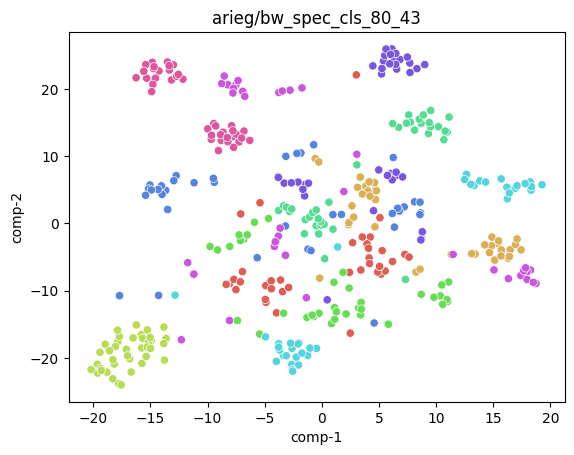

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X)

df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", num_ids),
                legend=None,
                data=df).set(title=f"{my_dataset}")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.002s...
[t-SNE] Computed neighbors for 400 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 1.964032
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.719112
[t-SNE] KL divergence after 1000 iterations: 0.659362


[Text(0.5, 1.0, 'arieg/bw_spec_cls_80_43')]

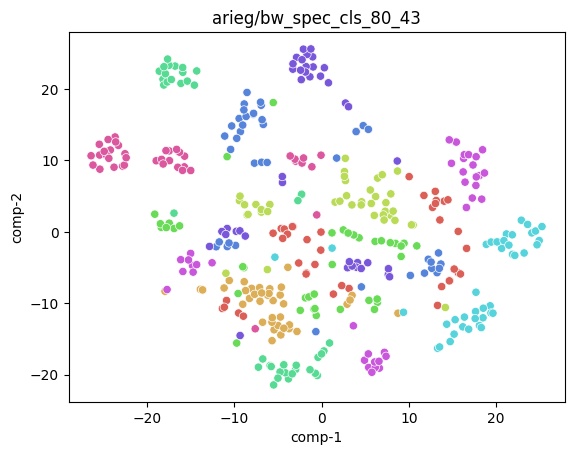

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X)

df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", num_ids),
                legend=None,
                data=df).set(title=f"{my_dataset}")

In [ ]:
!pip install -q datasets transformers librosa

In [ ]:
import huggingface_hub
huggingface_hub.login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# From https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import VGG19
import numpy as np

model_vgg19 = VGG19(include_top=False)

In [ ]:
def vgg19_image_embedding(image):
    #convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # predict the probability across all output classes
    yhat = model_vgg19.predict(image, verbose=0)

    return np.mean(yhat, axis=(1,2))    # shape = (1, 512)

In [ ]:
import PIL
from PIL import Image

def spec2image( spec ):
    '''
    Inputs:
        spec: Spectrogram as a numpy array
    Output:
        PIL Image
    '''
    spec = (spec - spec.min()) / (spec.max() - spec.min()) * 255
    spec = spec.astype('uint8')
    pil_image = PIL.Image.fromarray(spec)

    return pil_image

In [ ]:
from transformers import WhisperFeatureExtractor

whisper_feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [ ]:
def audio2image( array ):
    # Extract spectrogram from Whisper features. It's the first Whisper feature
    features = whisper_feature_extractor(
        array,
        sampling_rate=16_000,
        padding=True
    )
    spec =  features['input_features'][0]

    # Transform spectrogram to an image
    img = spec2image( spec ).resize(
        (298, 224),                           # suitable for google/vit-base-patch16-224-in21k AutoImageProcessor which has
                                              # image_processor.size["height"], image_processor.size["width"] = 224, 224
        Image.Resampling.LANCZOS).convert('RGB')

    return img

### All emebdding methods - calculation for fma_small

In [ ]:
import glob
from pathlib import Path
import librosa
from tqdm import tqdm
import numpy as np

embedding_methods = ['yamnet']

if 'vgg19' in embedding_methods:
    vgg19_embeddings = np.zeros((7997, 512), dtype='float32')
if 'openl3' in embedding_methods:
    openl3_embeddings = np.zeros((7997, 512), dtype='float32')
if 'yamnet' in embedding_methods:
    yamnet_embeddings = np.zeros((7997, 1024), dtype='float32')

ids = np.zeros(106_574, dtype='uint8')

idx = 0
for f in tqdm(glob.glob('fma_small/*/*.mp3')):
    # Create embeddings from audio
    try:
        array, sr = librosa.load(f)

        # vgg19
        if 'vgg19' in embedding_methods:
            img = audio2image( array )
            vgg19_embedding = vgg19_image_embedding( img )
            vgg19_embeddings[idx] = vgg19_embedding

        # openl3
        if 'openl3' in embedding_methods:
            openl3_embedding = openl3_audio_embedding( array, sr)
            openl3_embeddings[idx] = openl3_embedding

        # yamnet
        if 'yamnet' in embedding_methods:
            array = librosa.resample(array, orig_sr=sr, target_sr=16_000)
            _, yamnet_embedding, _ = yamnet_model(array)
            yamnet_embeddings[idx] = np.mean(yamnet_embedding, axis=0)

        ids[idx] = int( Path(f).stem )

        idx += 1
    except:
        print(f"Bad file {f}")

# Save embeddings
print(f"Completed {idx} embeddings")
if 'vgg19' in embedding_methods:
    np.save("/content/drive/MyDrive/Colab Notebooks/Zama/vgg19_embeddings.npy", vgg19_embeddings)
if 'openl3' in embedding_methods:
    np.save("/content/drive/MyDrive/Colab Notebooks/Zama/openl3_embeddings.npy", openl3_embeddings)
if 'yamnet' in embedding_methods:
    np.save("/content/drive/MyDrive/Colab Notebooks/Zama/yamnet_embeddings.npy", yamnet_embeddings)

np.save("/content/drive/MyDrive/Colab Notebooks/Zama/ids.npy", ids)    # PROBLEM indices depend on glob traversal order, and not on the dataset structure


0it [00:00, ?it/s]


Completed 0 embeddings


##### Save embeddings

### OpenL3 embeddings
https://openl3.readthedocs.io/en/latest/tutorial.html#extracting-audio-embeddings

In [ ]:
!pip install -q openl3

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Audio embedding
# Following https://github.com/SuperSonicHub1/spotify-audio-embeddings/blob/master/embed.py
import openl3
import skimage.measure

OPENL3_EMBEDDING_SIZE = 512
openl3_emb_model = openl3.models.load_audio_embedding_model(
    input_repr= "mel256",
    content_type= "music",
    embedding_size= OPENL3_EMBEDDING_SIZE)

def max_pool(embeddings):
	return skimage.measure.block_reduce(embeddings, (OPENL3_EMBEDDING_SIZE, 1), np.max)[0]

def openl3_audio_embedding( audio, smapling_rate):
     emb_hops, _ = openl3.get_audio_embedding(
            audio,
            smapling_rate,
            model= openl3_emb_model,
            verbose=0)

     return max_pool(emb_hops)

### Yamnet embeddings
https://keras.io/examples/audio/uk_ireland_accent_recognition/#yamnet-model
https://blog.tensorflow.org/2021/03/transfer-learning-for-audio-data-with-yamnet.html

In [ ]:
import tensorflow_hub as hub

yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

### Clusterization

In [ ]:
import numpy as np

embedding_method = 'yamnet'

embeddings = np.load(f"/content/drive/MyDrive/Colab Notebooks/Zama/{embedding_method}_embeddings.npy")[:7997]
ids = np.load('/content/drive/MyDrive/Colab Notebooks/Zama/ids.npy')[:7997]

In [ ]:
!pip install -q faiss-gpu
import faiss

ncentroids = 80
niter = 20
verbose = True
d = embeddings.shape[1]
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(embeddings)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.3 MB/s eta 0:00:00


60926.13671875

In [ ]:
# kmeans.centroids contains centroids' vectors
kmeans.centroids.shape

(80, 1024)

In [ ]:
D, I = kmeans.index.search(embeddings, 1)
# I is a mapping between tracks (i.e. track embeddings) and centroid (cluster) index

In [ ]:
I.shape

(7997, 1)

In [ ]:
np.save(f"/content/drive/MyDrive/Colab Notebooks/Zama/{embedding_method}_centroids.npy", kmeans.centroids)
np.save(f"/content/drive/MyDrive/Colab Notebooks/Zama/{embedding_method}_cluster_idxs.npy", I)

### Dataset for cluster classification

In [ ]:
import numpy as np

embedding_method = 'yamnet'

centroids = np.load(f"/content/drive/MyDrive/Colab Notebooks/Zama/{embedding_method}_centroids.npy")
I = np.load(f"/content/drive/MyDrive/Colab Notebooks/Zama/{embedding_method}_cluster_idxs.npy")

##### Embeddings TSNE

In [ ]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd

X = embeddings
y = I.squeeze()
my_dataset = 'embeddings'
num_clusters = 80
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X)

df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", num_clusters),
                legend=None,
                size=1,
                data=df).set(title=f"{my_dataset}")

##### Libs for image creation

In [ ]:
import PIL
from PIL import Image

def spec2image( spec ):
    '''
    Inputs:
        spec: Spectrogram as a numpy array
    Output:
        PIL Image
    '''
    spec = (spec - spec.min()) / (spec.max() - spec.min()) * 255
    spec = spec.astype('uint8')
    pil_image = PIL.Image.fromarray(spec)

    return pil_image

In [ ]:
from transformers import WhisperFeatureExtractor

whisper_feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [ ]:
def audio2image( array ):
    # Extract spectrogram from Whisper features. It's the first Whisper feature
    features = whisper_feature_extractor(
        array,
        sampling_rate=16_000,
        padding=True
    )
    spec =  features['input_features'][0]

    # Transform spectrogram to an image
    img = spec2image( spec ).resize(
        (298, 224),                           # suitable for google/vit-base-patch16-224-in21k AutoImageProcessor which has
                                              # image_processor.size["height"], image_processor.size["width"] = 224, 224
        Image.Resampling.LANCZOS).convert('RGB')

    return img

#### First time creation of Dataset for clusters classification

In [ ]:
import glob
from pathlib import Path
import librosa
from tqdm import tqdm
import os

# Create dataset
# takes ~30 min on T4
folder = '/content/drive/MyDrive/Colab Notebooks/Zama'
my_dataset = f"clustering_{embedding_method}_{ncentroids}"

idx = 0
for f in tqdm(glob.glob('fma_small/*/*.mp3')):
    # Create image from audio
    try:
        array, _ = librosa.load(f)
        img = audio2image( array )

        # Store image file
        label = int(I[idx])
        track_id = Path(f).stem

        path = f"{folder}/{my_dataset}/train/{label:03d}/"
        if not os.path.exists(path):
            os.makedirs(path)

        img.save(f"{path}/{track_id}.png")

        idx += 1
    except:
        print(f"Bad file {idx}")

In [ ]:
import huggingface_hub
huggingface_hub.login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from datasets import load_dataset

# Publish dataset
ds = load_dataset("imagefolder", data_dir=f"{folder}/{my_dataset}")
ds.push_to_hub(f"arieg/{my_dataset}")

Resolving data files:   0%|          | 0/7997 [00:00<?, ?it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/7997 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/80 [00:00<?, ?ba/s]

#### Creation of clusterization dataset based on existing dataset clustering_vgg19_80

In [ ]:
from datasets import load_dataset
baseline_ds = load_dataset("arieg/clustering_vgg19_80")['train']

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7997 [00:00<?, ? examples/s]

In [ ]:
def idx2cluster(sample, idx):
    sample['label'] = int(I[idx])
    return sample

clastering_ds = baseline_ds.map(idx2cluster, with_indices=True)

In [ ]:
my_dataset = f"clustering_{embedding_method}_{ncentroids}"

clastering_ds.push_to_hub(f"arieg/{my_dataset}")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/7997 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/80 [00:00<?, ?ba/s]

#### Creation of dataset of all FMA_small images with track_ids as labels
needed for negative pairs of siamese network

In [ ]:
import numpy as np

ids = np.load('/content/drive/MyDrive/Colab Notebooks/Zama/ids.npy')[:7997]

In [ ]:
def idx2track_id(sample, idx):
    sample['label'] = ids[idx]
    return sample

track_id_ds = baseline_ds.map(idx2track_id, with_indices=True)

In [ ]:
# 'siam_embedding' no more needed
ds = ds.remove_columns(['siam_embedding'])

#### Add embeddings for an image datset in case embeddings are already created (

In [ ]:
import numpy as np
embedding_method = 'siamese'

centroids = np.load(f"/content/drive/MyDrive/Colab Notebooks/Zama/{embedding_method}_centroids.npy")
I = np.load(f"/content/drive/MyDrive/Colab Notebooks/Zama/{embedding_method}_cluster_idxs.npy")

In [ ]:
def track_id2cluster(sample):
    sample['siam_cluster'] = int(I[ sample['track_id'] ])
    return sample

clustering_ds = ds.map(track_id2cluster)

Map:   0%|          | 0/39985 [00:00<?, ? examples/s]

In [ ]:
import huggingface_hub
huggingface_hub.login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
clustering_ds.push_to_hub(f"arieg/{dest_ds}")

Uploading the dataset shards:   0%|          | 0/5 [00:00<?, ?it/s]

Map:   0%|          | 0/7997 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/80 [00:00<?, ?ba/s]

Map:   0%|          | 0/7997 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/80 [00:00<?, ?ba/s]

Map:   0%|          | 0/7997 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/80 [00:00<?, ?ba/s]

Map:   0%|          | 0/7997 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/80 [00:00<?, ?ba/s]

Map:   0%|          | 0/7997 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/80 [00:00<?, ?ba/s]